# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\tmacc\AppData\Local\Temp\ipykernel_6744\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
!pip install imageio

     ---------------------------------------- 3.4/3.4 MB 558.8 kB/s eta 0:00:00


In [7]:
!pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [4]:
import numpy as np
import os

#from scipy.misc import imread, imresize
from imageio import imread
from PIL import Image as img
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [5]:
np.random.seed(30)
import random as rn
rn.seed(30)
#from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

ModuleNotFoundError: No module named 'tensorflow'

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
pwd()

'C:\\Users\\alexs\\OneDrive\\Documents\\PGDDS\\Deep Learning\\assignment'

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32

In [6]:
labels = list(train_doc)
labels = [int(x.strip().split(';')[2]) for x in labels]
classes = len(set(labels))
classes

5

In [7]:
# Images are two different sizes and aspect ratios (300,300) and (120,160)
# All images will be resized to 100,100 but to maintain aspect ratio some 
# top and bottom padding will be added in the form of black pixels [0,0,0]
# zero paddig was chosen as it will have minimal effect on the learning

def resize_image (img_array, new_width = 96):
    h,w,c = img_array.shape
    scale_factor = float(new_width / w)
    new_height = int(h * scale_factor)
    image = img.fromarray(img_array.astype(np.uint8)) # create PIL object
    new_img = image.resize((new_width,new_height), img.ANTIALIAS)
    new_img_array = np.array(new_img).astype(np.float32)
    return(new_img_array)

def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = img.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return (result)

def add_padding(img_array, desired_height = 96):
    h,w,c = img_array.shape
    if (h < desired_height):
        delta_height = desired_height - h
    
        pad = delta_height // 2
        pad_bottom = pad + (delta_height % 2)
        new_image_array = np.pad(img_array,[(pad,pad_bottom),(0,0),(0,0)],mode='constant',constant_values=0) # pad 0 axis only
        return (new_image_array)
    else:
        return(img_array)
    


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def igenerator(source_path, folder_list, batch_size,height=128, width=128):
    print( 'Source path = ', source_path, '; batch size =', batch_size, '; num Videos =', len(folder_list))
    #img_idx = list(range(0,30,3)) # take every 3rd frame from the video clip of 30 frames
    img_idx = [15] # take single frame from each video - to test image resize / padding
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),128,128,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    original_image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #image = imresize(image,(120,160))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_image(original_image, width) # resize images to ??? x 100 maintaining aspect ratio
                    image = add_padding(image, height) # add padding to top and bottom of image to make image 100x100
                    
                    #batch_data[folder,idx,:,:,0] = image[:,:,0] #-np.mean(image[:,:,0])
                    #batch_data[folder,idx,:,:,1] = image[:,:,1] #-np.mean(image[:,:,1])
                    #batch_data[folder,idx,:,:,2] = image[:,:,2] #-np.mean(image[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            #yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            yield original_image, image
        
        # write the code for the remaining data points which are left after full batches
        #if len(folder_list) % batch_size:
            

In [9]:
def generator(source_path, folder_list, batch_size, height=128, width=128):
    print( 'Source path = ', source_path, '; batch size =', batch_size, '; num Videos =', len(folder_list))
    img_idx = list(range(0,30,2)) # take every 2nd frame from the video clip of 30 frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    original_image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #image = imresize(image,(120,160))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_image(original_image, new_width=width) # resize images to 100x??? maintaining aspect ratio
                    #image = add_padding(image, desired_height = height) # add padding to top and bottom of image to make image 100x100
                    
                    #Normalise the Image channels
                    image[:,:,0] = (image[:,:,0] / 255) 
                    image[:,:,1] = (image[:,:,1] / 255) 
                    image[:,:,2] = (image[:,:,2] / 255) 
                    
                    #standardize the Image channels
                    #image[:,:,0] = (image[:,:,0]- np.mean(image[:,:,0])) / np.std(image[:,:,0])
                    #image[:,:,1] = (image[:,:,1]- np.mean(image[:,:,1])) / np.std(image[:,:,1])
                    #image[:,:,2] = (image[:,:,2]- np.mean(image[:,:,2])) / np.std(image[:,:,2])
                    
                    #add padding with zero to avoid changing the mean of the actual image channels
                    image = add_padding(image, desired_height = height) # add padding to top and bottom of image to make image correct height
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] 
                    batch_data[folder,idx,:,:,1] = image[:,:,1] 
                    batch_data[folder,idx,:,:,2] = image[:,:,2] 
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
        
        # write the code for the remaining data points which are left after full batches
        
        imgs_left = len(folder_list) % batch_size
        if imgs_left:
            batch += 1
            for folder in range(imgs_left):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    original_image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #image = imresize(image,(120,160))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_image(original_image, new_width=width) # resize images to 100x??? maintaining aspect ratio
                    #image = add_padding(image, desired_height = height) # add padding to top and bottom of image to make image 100x100
                    
                    
                    
                    #Normalise the Image channels
                    image[:,:,0] = (image[:,:,0] / 255) 
                    image[:,:,1] = (image[:,:,1] / 255) 
                    image[:,:,2] = (image[:,:,2] / 255) 
                    
                    #standardize the Image channels
                    #image[:,:,0] = (image[:,:,0]- np.mean(image[:,:,0])) / np.std(image[:,:,0])
                    #image[:,:,1] = (image[:,:,1]- np.mean(image[:,:,1])) / np.std(image[:,:,1])
                    #image[:,:,2] = (image[:,:,2]- np.mean(image[:,:,2])) / np.std(image[:,:,2])
                    
                    #add padding with zero to avoid changing the mean of the actual image channels
                    image = add_padding(image, desired_height = height) # add padding to top and bottom of image to make image 100x100
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] 
                    batch_data[folder,idx,:,:,1] = image[:,:,1] 
                    batch_data[folder,idx,:,:,2] = image[:,:,2] 
                    
                    
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
                
            

### Check image resizing and padding
Before passing data to model lets qhickly visualize what the resize_image and add_padding functions are doing

In [10]:
train_path = 'Project_data/train'
image_generator = igenerator(train_path, train_doc, 1, 96, 96)

In [11]:
for i in range(1):
    original_image, image= next(image_generator)
print('original image = ', original_image.shape)
print('new image = ', image.shape)

Source path =  Project_data/train ; batch size = 1 ; num Videos = 663
original image =  (120, 160, 3)
new image =  (96, 96, 3)


(120, 160, 3)


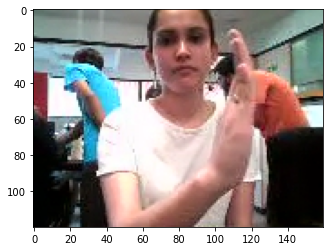

In [12]:
o_image = original_image.astype(int)
print(o_image.shape)
plt.imshow(o_image)
plt.show()


(96, 96, 3)


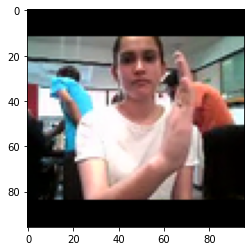

In [13]:
image = image.astype(int)
print(image.shape)
plt.imshow(image)
plt.show()


In [14]:
dummy_gen = generator(train_path, train_doc, batch_size, 96, 96)

In [15]:
%%time
data, labels= next(dummy_gen)
print(data.shape)
print(labels.shape)

Source path =  Project_data/train ; batch size = 32 ; num Videos = 663
(32, 15, 96, 96, 3)
(32, 5)
Wall time: 1.58 s


[0. 0. 0. 1. 0.]


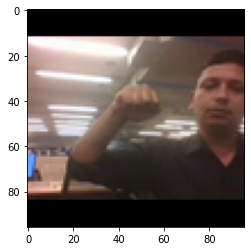

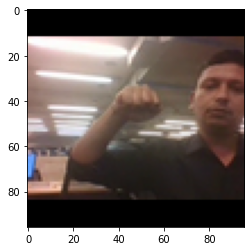

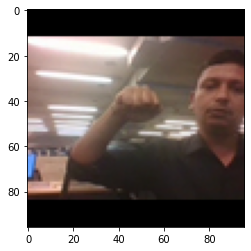

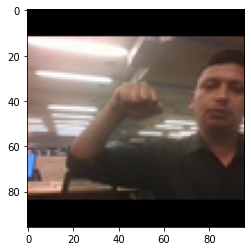

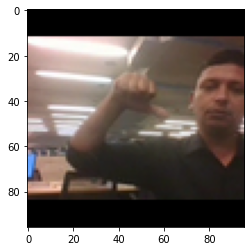

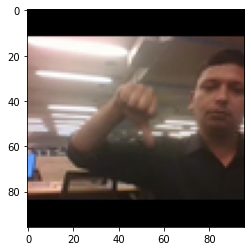

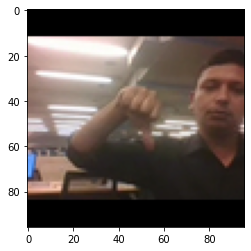

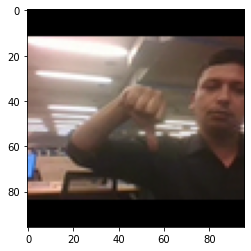

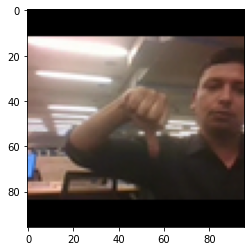

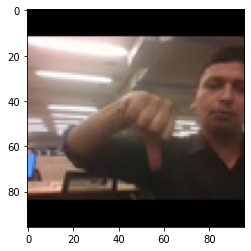

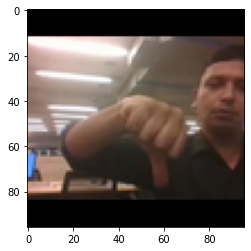

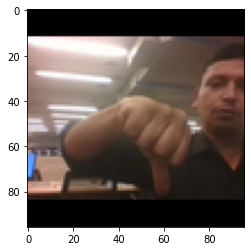

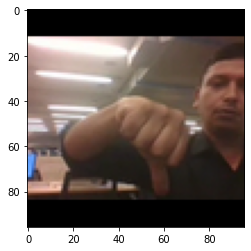

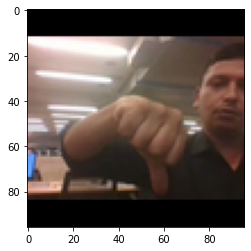

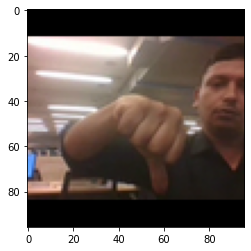

[1. 0. 0. 0. 0.]


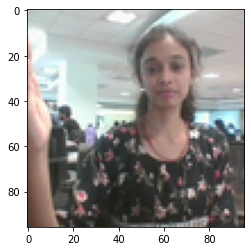

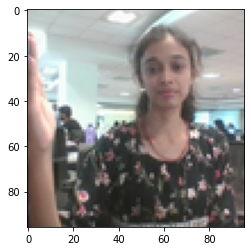

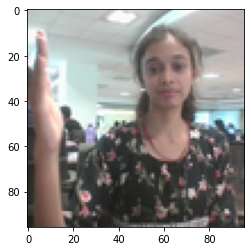

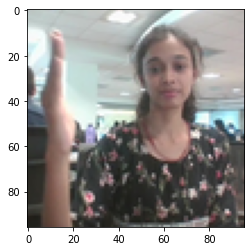

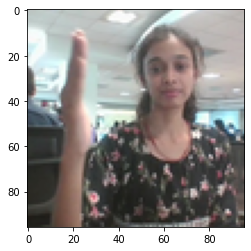

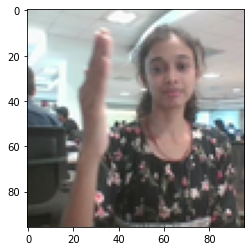

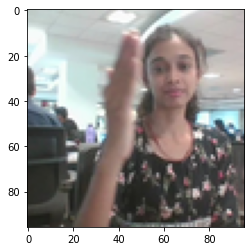

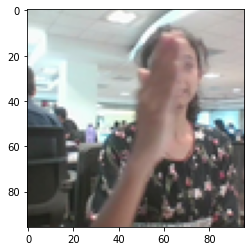

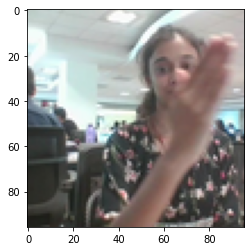

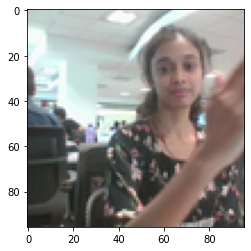

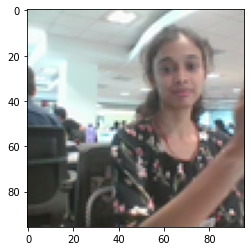

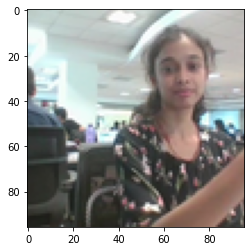

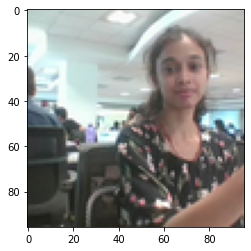

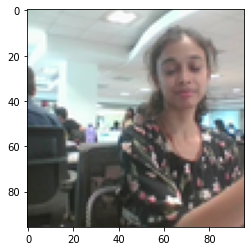

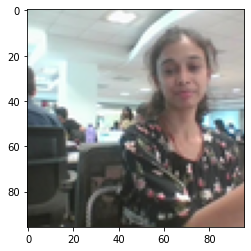

In [16]:
for x in range(2):
    print(labels[x,:])
    for y in range(15):
        plt.imshow(data[x,y,:,:,:])
        plt.show()
    

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [17]:
train_path = 'Project_data/train'
val_path = 'Project_data/val'

num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

batch_size = 32
num_epochs = 30 # choose the number of epochs
initial_LR = 0.0003

image_h = 96
image_w = 96

In [18]:
curr_dt_time = datetime.datetime.now()



## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers

sample_shape = (15,image_h,image_w,3) # frames per video, h, w, c
no_classes = 5

model = Sequential()

model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.15))

model.add(Conv3D(64, kernel_size=(3,3,3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(no_classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [20]:
optimiser = tf.keras.optimizers.Adam(learning_rate = initial_LR) # default LR
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 13, 94, 94, 32)    2624      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 47, 47, 32)     0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 47, 47, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 4, 45, 45, 64)     55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 22, 22, 64)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 22, 22, 64)     0         
_________________________________________________________________
flatten (Flatten)            (None, 61952)             0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [21]:
train_generator = generator(train_path, train_doc, batch_size, image_h, image_w)
val_generator = generator(val_path, val_doc, batch_size, image_h, image_w)

In [22]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)


LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-6)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
callbacks_list = [cp,LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [24]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\alexs\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  Project_data/train ; batch size = 32 ; num Videos = 663
Epoch 1/30
21/21 [==============================] - 171s 8s/step - loss: 3.4647 - categorical_accuracy: 0.2381 - val_loss: 1.6316 - val_categorical_accuracy: 0.2266

Epoch 00001: val_loss improved from inf to 1.63155, saving model to model_init_2021-12-1219_47_46.109835\model-00001-3.46465-0.23810-1.63155-0.22656.h5
Epoch 2/30
21/21 [==============================] - 169s 8s/step - loss: 1.6384 - categorical_accuracy: 0.2307 - val_loss: 1.6311 - val_categorical_accuracy: 0.2422

Epoch 00002: val_loss improved from 1.63155 to 1.63110, saving model to model_init_2021-12-1219_47_46.109835\model-00002-1.63841-0.23065-1.63110-0.24219.h5
Epoch 3/30
21/21 [==============================] - 169s 8s/step - loss: 1.5918 - categorical_accuracy: 0.2812 - val_loss: 1.6068 - val_categorical_accuracy: 0.3281

Epoch 00003: val_loss improved from 1.63110 to 1.60682, saving model to model_init_2021-12-1219_47_46.109835\model-00003-1.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])
Test Accuracy =  0.8645833134651184
Val  Accuracy =  0.8203125
Avg Test Accuracy =  0.8544973532358805
Avg Val  Accuracy =  0.7881944444444444


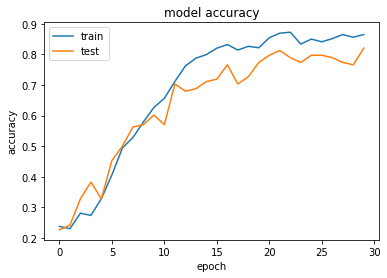

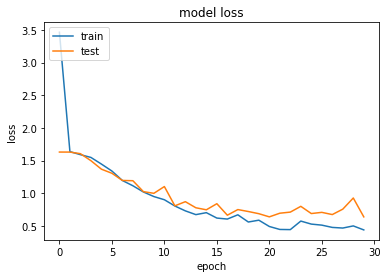

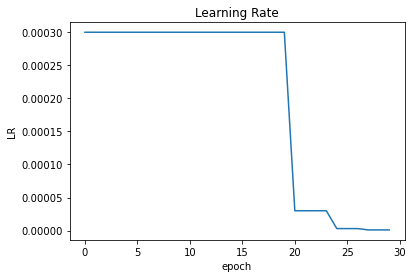


HYPERPARAMS
# training sequences = 663
# validation sequences = 100
# epochs = 30
# Batch Size = 32
# Initial LR = 0.0003
# Optimizer :  <keras.optimizer_v2.adam.Adam object at 0x000002544F078580>


In [25]:
# list all data in history
print(history.history.keys())
print('Test Accuracy = ',history.history['categorical_accuracy'][-1])
print('Val  Accuracy = ',history.history['val_categorical_accuracy'][-1])
print('Avg Test Accuracy = ',np.mean(history.history['categorical_accuracy'][-10:-1]))
print('Avg Val  Accuracy = ',np.mean(history.history['val_categorical_accuracy'][-10:-1]))
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# show learning rate
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.ylabel('LR')
plt.xlabel('epoch')
plt.show()

print('\nHYPERPARAMS')
print(  '===========')
print('# training sequences =', num_train_sequences)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)
print ('# Batch Size =', batch_size)
print ('# Initial LR =', initial_LR)
print ('# Optimizer : ', optimiser)

In [26]:
import jovian
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "alexsmith3816/neural-nets-project-conv3d-final" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/alexsmith3816/neural-nets-project-conv3d-final


'https://jovian.ai/alexsmith3816/neural-nets-project-conv3d-final'